In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats
import pdb
import json
from math import sqrt

In [12]:
file_csv = '/mnt/disk15tb/paula/Main_DA_Projects/data_analysis_output/Primary Neurons/CDKL5_T1_nov16/ActivityScan_outputs/Compiled_ActivityScan.csv'

data_df = pd.read_csv(file_csv)

In [13]:
df = data_df.replace(np.NaN,0.0)
df

,Run_ID,DIV,Well,NeuronType,Time,Chip_ID,Mean_FiringRate,Mean_SpikeAmplitude,Active_area
0,5,5,1,MxHEMI,20-May-2024 09:43:53,M07039,0.601701,72.853541,25.606061
1,5,5,2,MxWT,20-May-2024 09:43:53,M07039,1.005935,49.774901,15.848485
2,5,5,3,FxHET,20-May-2024 09:43:53,M07039,0.668804,68.087166,14.712121
3,5,5,4,MxHEMI,20-May-2024 09:43:53,M07039,0.465627,74.338109,21.621212
4,5,5,5,MxWT,20-May-2024 09:43:53,M07039,0.859133,48.574638,15.787879
...,...,...,...,...,...,...,...,...,...
235,123,30,2,MxWT,14-Jun-2024 12:01:45,M08018,3.413517,86.469342,84.655303
236,123,30,3,FxHET,14-Jun-2024 12:01:45,M08018,3.110461,90.509724,91.484848
237,123,30,4,MxHEMI,14-Jun-2024 12:01:45,M08018,3.554393,86.857807,86.674242
238,123,30,5,MxWT,14-Jun-2024 12:01:45,M08018,2.317599,119.773141,87.981061


In [14]:
div = df['DIV'].unique()
print(div)


[ 5  8 13 16 20 23 27 30]


In [15]:
chip_id = df['Chip_ID'].unique()
print(chip_id)

['M07039' 'M07420' 'M07427' 'M08018']


In [16]:
df['NeuronType'] = df['NeuronType'].str.strip()
unique_genotypes = df['NeuronType'].unique()
#unique_genotypes =['WT cortex','HET cortex']
print(unique_genotypes)

['MxHEMI' 'MxWT' 'FxHET']


## Without outlier removal

In [7]:
df.columns

Index(['Run_ID', 'DIV', 'Well', 'NeuronType', 'Time', 'Chip_ID',
       'Mean_FiringRate', 'Mean_SpikeAmplitude', 'Active_area'],
      dtype='object')

In [8]:
colors = ['royalblue','brown']
markers = ['o','s','d','*','^']

In [ ]:
output_types = output_types =[ 'Mean_FiringRate', 'Mean_SpikeAmplitude', 'Active_area']

dirpath = '/home/mmp/Documents/SYNGAP_t2_march2024/'
for output_type in output_types:
    total_genotypes = len(unique_genotypes)
    #output_type='Number_Bursts'
    # Print the number of unique genotypes
    print(f"Number of unique Genotypes: {total_genotypes}")

    # Initialize output arrays for each unique genotype
    output_arrays = {genotype: [] for genotype in unique_genotypes}
    chip_arrays = {genotype: [] for genotype in unique_genotypes}
    well_arrays = {genotype: [] for genotype in unique_genotypes}
    print(unique_genotypes)
    # Fill data from data frame
    for i in div:
        for genotype in unique_genotypes:
            temp_df = df.loc[(df['DIV'] == i) &
                            (df['NeuronType'].str.strip() == genotype)
                            ]
            output_arrays[genotype].append(np.array(temp_df[output_type]))
            chip_arrays[genotype].append(np.array(temp_df['Chip_ID']))
            well_arrays[genotype].append(np.array(temp_df['Well']))
    #print(df)
    # Adjust bar width and gap between them
    bar_width = 0.25  # Adjust as necessary for your specific plot
    gap_between_bars = 0  # Adjust the gap between bars within a group

    # Calculate the total width for all bars in a group
    total_bar_group_width = total_genotypes * bar_width + (total_genotypes - 1) * gap_between_bars

    # Create x-coordinates of bars for each genotype group
    x_genotype = {genotype: [] for genotype in unique_genotypes}
    base_x_coordinate = np.arange(len(div))  # Base x-coordinates for each group
    offset = (total_genotypes * bar_width + (total_genotypes - 1) * gap_between_bars) / 2
    centered_x = base_x_coordinate - offset + bar_width / 2
    for i, genotype in enumerate(unique_genotypes):
        x_genotype[genotype] = centered_x + i * (bar_width + gap_between_bars)



    # Initialize plot
    fig, ax = plt.subplots()
    # Generate a list of distinct colors based on the number of genotypes
    #colors = [plt.colormaps['Set1'](i) for i in np.linspace(0, 1, len(unique_genotypes))]# Using a colormap to generate colors
    #colors2 = [plt.colormaps['Set2'](i) for i in np.linspace(0, 1, len(unique_genotypes))]#
    # marker_shapes = ['^', 's', 'v', 'D', '+', 'x', '*', 'H', '8']
    # marker_chips={chip:marker_shapes[idx] for idx, chip in enumerate(track_chips)}
    # Plot data for each genotype
    mean_data_all ={}
    yerr_data_all = {}
    n_data_all={}
    #breakpoint()
    #pdb.set_trace()
    for i,genotype in enumerate(unique_genotypes):
        #breakpoint()
        y_data = output_arrays[genotype]
        chipy_data = chip_arrays[genotype]
        welly_data = well_arrays[genotype]
        #print("type: ",type(genotype))
        # Calculate statistics
        mean_data = [np.mean([n for n in yi if np.isfinite(n)]) for yi in y_data]
        yerr_data = [np.std([n for n in yi if np.isfinite(n)], ddof=1)/np.sqrt(np.size(yi)) for yi in y_data]
        n_data = [len(yi) for yi in y_data]
        # Store statistics in dictionaries
        mean_data_all[genotype] = mean_data
        yerr_data_all[genotype] = yerr_data
        n_data_all[genotype] = n_data
        
            
        # Plot bars
        #transparency value 
        alpha_value = 0.5
        ax.bar(x_genotype[genotype], mean_data, yerr=yerr_data, capsize=3, width=bar_width, color=colors[i], edgecolor='black', ecolor='black', label=genotype,alpha=0.6)

        #pdb.set_trace()
        # Plot scatter points
        #breakpoint()
        for j in range(len(x_genotype[genotype])):
            #pdb.set_trace()
            # ax.scatter(x_genotype[genotype][j] + np.zeros(y_data[j].size), y_data[j], s=20,color=colors2[i],marker=marker_chips[chipy_data[j]+str(welly_data[j])] if chipy_data[j]+str(welly_data[j]) in track_chips else 'o')
    # Concatenate corresponding elements from chipy_data[j] and welly_data[j]
            combined_data = [str(chip)+ str(well) for chip, well in zip(chipy_data[j], welly_data[j])]

            # # Check if the concatenated string is in track_chips, and set the marker accordingly
            # markers = [marker_chips.get(chipwell, 'o') for chipwell in combined_data]
            # #marker_chips[combined_data[0]] if combined_data[0] in track_chips else 'o'

            # Use the marker in the scatter plot
            jitter_amount=0.07
            for k in range(len(y_data[j])):
                #pdb.set_trace()
                ax.scatter(
                    x_genotype[genotype][j] + np.random.uniform(-jitter_amount, jitter_amount, 1),
                    y_data[j][k],
                    s=10,
                    color=colors[i],
                    marker=markers[i]
                        )


    # # Calculate maximum y-value for plotting significance
    # max_y = max([max(data) for data in output_arrays.values() if data.size > 0])
    # increment = max_y * 0.1  # Increment to adjust y-position for significance markers

    #Perform and plot t-tests between all pairs of genotype
    #pdb.set_trace()
    for i in range(len(base_x_coordinate)):
        #maxim = max([max( output_arrays[genotype][i] )for genotype in unique_genotypes])
        maxim = max(max(array) for genotype_arrays in output_arrays.values() for array in genotype_arrays)
        count = 1
        p_values = []
        for j, genotype1 in enumerate(unique_genotypes):
            for k, genotype2 in enumerate(unique_genotypes):
                if j < k:
                    #pdb.set_trace()
                    #print("mean_data_all",mean_data_all[genotype1])
                    #print("type:",type(genotype1))
                    mean1, sem1, n1 = mean_data_all[genotype1][i], yerr_data_all[genotype1][i], n_data_all[genotype1][i]
                    mean2, sem2, n2 = mean_data_all[genotype2][i], yerr_data_all[genotype2][i], n_data_all[genotype2][i]
                    #t_stat, p_value = stats.ttest_ind_from_stats(mean1, sem1, n1, mean2, sem2, n2)
                    sed = sqrt(sem1**2.0 + sem2**2.0)
                    t_stat = (mean1 - mean2) / sed
                    # degrees of freedom
                    degreef = n1+n2 - 2
                    alpha=0.05
                    # calculate the critical value
                    cv = stats.t.ppf(1.0 - alpha, degreef)
                    # calculate the p-vallue
                    p_value = (1.0 - stats.t.cdf(abs(t_stat), degreef)) * 2.0
                    p_values.append([mean1,sem1,mean2,sem2,p_value])

                    # Plot significance
                    #maxim = max(np.max(output_arrays[genotype1][i]), np.max(output_arrays[genotype2][i]))
                    x1, x2 = x_genotype[genotype1][i], x_genotype[genotype2][i]
                    
                    sign = "***" if p_value <= 0.001 else "**" if p_value <= 0.01 else "*" if p_value <= 0.05 else "ns"
                    if not sign =='ns':
                        ax.plot([x1, x2], [maxim + 0.05*maxim*(count)] * 2, 'k', linewidth=1.5)
                        ax.text((x1 + x2) / 2, maxim +0.05*maxim*(count), sign, ha='center', va='bottom', fontsize=7)
                        ax.axvline(x1,color='black',linestyle=':',linewidth=0.5)
                        ax.axvline(x2,color='black',linestyle=':',linewidth=0.5)
                    count = count +1

                    


   # Adjustments for plot aesthetics
    plt.title(f"{output_type}", fontsize=14)
    plt.xlabel('DIV', fontsize=12)
    plt.ylabel(f"{output_type}", fontsize=12)
    plt.xticks(base_x_coordinate, div, fontsize=10)
    plt.legend(title='NeuronType', loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    plt.tight_layout()  # Adjust layout to prevent clipping of ylabel
    #plt.legend(title='NeuronType',loc='upper right', fontsize='x-small', handlelength=2, handletextpad=2, handleheight=2,bbox_to_anchor=(1.0, 1))
    import os 
    
    if not os.path.exists(dirpath):
            os.makedirs(dirpath)
    plt.savefig(f"{dirpath}/{output_type}.svg",dpi=300,format='svg')

## With the outlier removal


can remove the outliers based on the AE and parametric exploration

if maxone

In [ ]:
chip_id_exclude = [16867,18662]
if chip_id_exclude:
    # Using list comprehension for filtering
    print("hello")
    mask = [((row.Chip_ID in chip_id_exclude)) for index, row in df.iterrows()]

    df = df[~pd.Series(mask)]

In [ ]:
chip_id = df['Chip_ID'].unique()
print(chip_id)

if MAxtwo

In [ ]:
#exclude chips

#maxtwo exclude
exclude_dict = {'M07295':3}

if exclude_dict:
    # Using list comprehension for filtering
    print("hello")
    mask = [(row.Type=='xx')or(row.Type=='yy') or ((row.Chip_ID in exclude_dict) and (row.Well == exclude_dict[row.Chip_ID])) for index, row in df.iterrows()]

    df = df[~pd.Series(mask)]

In [ ]:
df.columns

In [ ]:
colors = ['royalblue','indianred']
markers=['s','o']

In [ ]:
output_types = ['IBI',
       'Burst_Peak', 'Number_Bursts', 'Spike_per_Burst', 'BurstDuration',]
dirpath = '/home/mmp/Documents/KCNT1_GRANT_MAY2024/KCNT1_hyperbursts/'
div = [9]

for output_type in output_types:
    total_genotypes = len(unique_genotypes)
    print(f"Number of unique Genotypes: {total_genotypes}")

    output_arrays = {genotype: [] for genotype in unique_genotypes}
    chip_arrays = {genotype: [] for genotype in unique_genotypes}
    well_arrays = {genotype: [] for genotype in unique_genotypes}
    
    for i in div:
        for genotype in unique_genotypes:
            temp_df = df.loc[(df['DIV'] == i) & (df['NeuronType'].str.strip() == genotype)]
            output_arrays[genotype].append(np.array(temp_df[output_type]))
            chip_arrays[genotype].append(np.array(temp_df['Chip_ID']))
            well_arrays[genotype].append(np.array(temp_df['Well']))
    
    bar_width = 0.5  # Slimmer bar width
    gap_between_bars = 0.0  # Small gap between bars within a group
    gap_between_groups = bar_width  # Gap between groups of bars

    total_bar_group_width = total_genotypes * bar_width + (total_genotypes - 1) * gap_between_bars
    total_plot_width = len(div) * (total_bar_group_width + gap_between_groups) + gap_between_groups

    x_genotype = {genotype: [] for genotype in unique_genotypes}
    base_x_coordinate = np.arange(len(div)) * (total_bar_group_width + gap_between_groups) + gap_between_groups + bar_width
    print(base_x_coordinate)
    offset = (total_genotypes * bar_width + (total_genotypes - 1) * gap_between_bars) / 2
    centered_x = base_x_coordinate - offset + bar_width / 2
    for i, genotype in enumerate(unique_genotypes):
        x_genotype[genotype] = centered_x + (i) * (bar_width + gap_between_bars)

    fig, ax = plt.subplots()
    mean_data_all = {}
    yerr_data_all = {}
    n_data_all = {}

    for i, (genotype, color, marker) in enumerate(zip(unique_genotypes, colors, markers)):
        y_data = output_arrays[genotype]
        chipy_data = chip_arrays[genotype]
        welly_data = well_arrays[genotype]
        mean_data = [np.mean([n for n in yi if np.isfinite(n)]) for yi in y_data]
        yerr_data = [np.std([n for n in yi if np.isfinite(n)], ddof=1) / np.sqrt(np.size(yi)) for yi in y_data]
        n_data = [len(yi) for yi in y_data]
        mean_data_all[genotype] = mean_data
        yerr_data_all[genotype] = yerr_data
        n_data_all[genotype] = n_data
        
        alpha_value = 0.5
        ax.bar(x_genotype[genotype], mean_data, yerr=yerr_data, capsize=3, width=bar_width, color=color, label=genotype, alpha=0.7)

        jitter_amount = 0.07
        for j in range(len(x_genotype[genotype])):
            combined_data = [str(chip) + str(well) for chip, well in zip(chipy_data[j], welly_data[j])]
            for k in range(len(y_data[j])):
                ax.scatter(
                    x_genotype[genotype][j] + np.random.uniform(-jitter_amount, jitter_amount, 1),
                    y_data[j][k],
                    s=20,
                    color=color,
                    marker=marker
                )

    for i in range(len(base_x_coordinate)):
        maxim = max(max(array) for genotype_arrays in output_arrays.values() for array in genotype_arrays)
        count = 1
        p_values = []
        for j, genotype1 in enumerate(unique_genotypes):
            for k, genotype2 in enumerate(unique_genotypes):
                if j < k:
                    mean1, sem1, n1 = mean_data_all[genotype1][i], yerr_data_all[genotype1][i], n_data_all[genotype1][i]
                    mean2, sem2, n2 = mean_data_all[genotype2][i], yerr_data_all[genotype2][i], n_data_all[genotype2][i]
                    sed = sqrt(sem1**2.0 + sem2**2.0)
                    t_stat = (mean1 - mean2) / sed
                    degreef = n1 + n2 - 2
                    alpha = 0.05
                    cv = stats.t.ppf(1.0 - alpha, degreef)
                    p_value = (1.0 - stats.t.cdf(abs(t_stat), degreef)) * 2.0
                    p_values.append([mean1, sem1, mean2, sem2, p_value])

                    x1, x2 = x_genotype[genotype1][i], x_genotype[genotype2][i]
                    sign = "***" if p_value <= 0.001 else "**" if p_value <= 0.01 else "*" if p_value <= 0.05 else "ns"
                    if sign != 'ns':
                        ax.plot([x1, x2], [maxim + 0.05 * maxim * (count)] * 2, 'k', linewidth=1.5)
                        #ax.text((x1 + x2) / 2, maxim + 0.05 * maxim * (count), f"{sign} ({round(p_value, 3)})", ha='center', va='bottom', fontsize=7)
                        ax.text((x1 + x2) / 2, maxim + 0.05 * maxim * (count), f"{sign}", ha='center', va='bottom', fontsize=7)
                        #ax.axvline(x1, color='black', linestyle=':', linewidth=0.5)
                        #ax.axvline(x2, color='black', linestyle=':', linewidth=0.5)
                    else:
                        ax.plot([x1, x2], [maxim + 0.05 * maxim * (count)] * 2, 'k', linewidth=1.5)
                        ax.text((x1 + x2) / 2, maxim + 0.05 * maxim * (count), f"{sign}", ha='center', va='bottom', fontsize=7)
                        #ax.axvline(x1, color='black', linestyle=':', linewidth=0.5)
                        #ax.axvline(x2, color='black', linestyle=':', linewidth=0.5)
                    count += 1
                    y_ticks = ax.get_yticks()
                    y_ticks_selected = [y_ticks[0], y_ticks[len(y_ticks) // 2], y_ticks[-1]]
                    ax.set_yticks(y_ticks_selected)
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
    plt.title(f"{output_type}", fontsize=14)
    plt.xlabel('DIV', fontsize=12)
    plt.ylabel(f"{output_type}", fontsize=12)
    plt.xticks(base_x_coordinate, div, fontsize=10)
    plt.legend(title='NeuronType', loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    plt.tight_layout()
    plt.xlim([0, total_plot_width])
    
    import os 
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
    plt.savefig(f"{dirpath}/{output_type}.svg", dpi=300, format='svg')
    plt.savefig(f"{dirpath}/{output_type}.png", format='png')
    plt.show()

#Aggregating the DIV data

In [18]:
unique_genotypes

array(['MxHEMI', 'MxWT', 'FxHET'], dtype=object)

In [21]:
#order
unique_genotypes = [ 'MxWT','MxHEMI', 'FxHET']

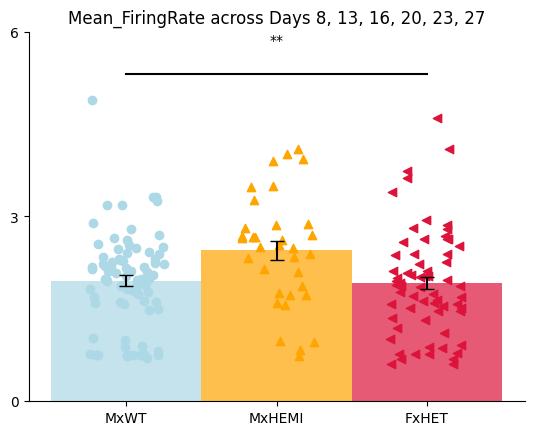

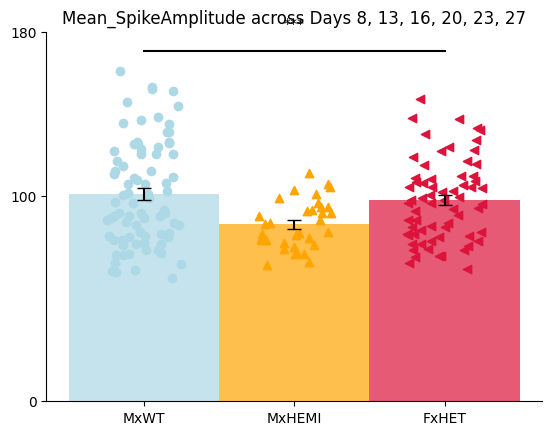

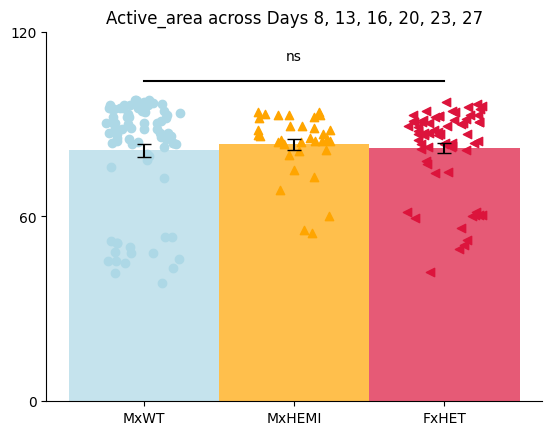

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import sqrt

# Parameters
div = [8, 13, 16, 20, 23, 27]  # Days to consider for analysis
output_types = ['Mean_FiringRate', 'Mean_SpikeAmplitude', 'Active_area']
dirpath = '/home/mmp/Documents/KCNT1_GRANT_MAY2024/KCNT1_T1_MAY6/'

# Custom colors for each genotype
custom_colors = {
    'MxWT': 'lightblue',
    'MxHEMI': 'orange',
    'FxHET': 'crimson',  # Add more genotypes and colors as needed
}

# Define marker types for scatter points
default_markers = ['o', '^', '<', '>', 's', '*', 'p', 'H', 'X', 'D']

# Create the directory if it does not exist
if not os.path.exists(dirpath):
    os.makedirs(dirpath)

# Process each output type
for output_type in output_types:
    fig, ax = plt.subplots()

    # Define parameters for the bar plot
    bar_width = 0.5
    base_x_position = 0.5  # Starting position for bars
    total_plot_width = len(unique_genotypes) * bar_width + bar_width

    # Store data for statistical analysis
    data_summary = {}
    positions = []

    for i, genotype in enumerate(unique_genotypes):
        # Filter and aggregate data
        filtered_data = df[df['DIV'].isin(div) & (df['NeuronType'].str.strip() == genotype)]
        aggregated_data = filtered_data[output_type].dropna()
        chips = filtered_data['Chip_ID'].dropna()

        # Calculate mean and SEM
        mean = np.mean(aggregated_data)
        SEM = np.std(aggregated_data) / sqrt(len(aggregated_data))

        # Store data for statistical comparisons
        data_summary[genotype] = (mean, SEM, aggregated_data)

        # Bar position and plot
        x_position = base_x_position + i * bar_width
        positions.append(x_position)

        # Use custom color or fallback to color map
        color = custom_colors.get(genotype, plt.cm.Set1(i / len(unique_genotypes)))

        # Bar plot for the genotype
        ax.bar(
            x_position, mean, yerr=SEM, width=bar_width,
            color=color, label=f"{genotype}", capsize=5, alpha=0.7
        )

        # Scatter plot with jittered points
        jitter = 0.25 * bar_width
        for chip, value in zip(chips, aggregated_data):
            jittered_x = x_position + np.random.uniform(-jitter, jitter)
            ax.scatter(jittered_x, value, marker=default_markers[i % len(default_markers)], color=color)

    # Perform statistical comparison between genotypes
    combined_data = [data_summary[genotype][2] for genotype in unique_genotypes]
    t_stat, p_value = stats.ttest_ind(combined_data[0], combined_data[1], equal_var=False)
    max_y = max([max(data) for data in combined_data])
    min_y = min([min(data) for data in combined_data])

    # Annotate significance
    sign = "***" if p_value <= 0.001 else "**" if p_value <= 0.01 else "*" if p_value <= 0.05 else "ns"

    # Extend the y-coordinate to match the number of positions
    y_values = [max_y + 0.1 * (max_y - min_y)] * len(positions)

    # Draw a horizontal line over all positions
    ax.plot(positions, y_values, 'k-', lw=1.5)

    # Annotate the p-value significance in the middle of the positions
    ax.text(
        np.mean(positions), max_y + 0.2 * (max_y - min_y), f'{sign}',
        ha='center', va='bottom'
    )

    # Customize plot aesthetics
    y_ticks = ax.get_yticks()
    y_ticks_selected = [y_ticks[0], y_ticks[len(y_ticks) // 2], y_ticks[-1]]
    ax.set_yticks(y_ticks_selected)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(f"{output_type} across Days 8, 13, 16, 20, 23, 27")
    plt.xticks(positions, unique_genotypes)
   